# Import bibliotek i podstawowe ustawienia

In [4]:
# import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Zignorowanie ostrzeżeń
warnings.filterwarnings("ignore")

# Ustawienie stylu wykresów 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

c:\Users\jarem\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Wczytanie danych z systemu STRATEG i wstępna obróbka

In [146]:
df = pd.read_excel('dane_strateg.xlsx')

Ustawienie indeksu

In [147]:
df.rok = pd.to_datetime(df.rok, format="%Y")
df = df.set_index(df.rok.dt.year)
df.drop('rok', axis=1, inplace=True)
df

,udzial_msp,przych_eksport,naklady_inw,przewozy
rok,,,,
2003,.,7867.2,.,.
2004,.,8222.4,.,.
2005,.,8479.2,.,.
2006,.,9233.8,.,.
2007,.,11356.0,.,314.06
2008,17,9883.9,.,309.77
2009,15.6,10877.4,.,272.56
2010,15,12064.3,.,267.97
2011,14.2,15331.2,.,274.4


# Prognozy wskaźników

## 1. UDZIAŁ MAŁYCH I ŚREDNICH PRZEDSIĘBIORSTW aktywnych innowacyjnie w ogólnej liczbie małych i średnich przedsiębiorstw w Polsce Wschodniej [%]

### 1.1. Przygotowanie danych

In [148]:
# Stworzenie zbioru danych dla wskaźnika
msp = df[['udzial_msp']]

# Usunięcie braków danych (zaznaczonych jako kropka, ".")
msp = msp[msp['udzial_msp'] != "."]

# Inspekcja danych
msp

,udzial_msp
rok,
2008,17
2009,15.6
2010,15
2011,14.2
2012,14.4
2013,14.6
2014,15
2015,13.5
2016,16.1


In [149]:
msp.udzial_msp = msp.udzial_msp.astype(float)

### 1.2. Analiza eksploracyjna

In [150]:
# Określenie y
x = msp.index
y = msp.udzial_msp


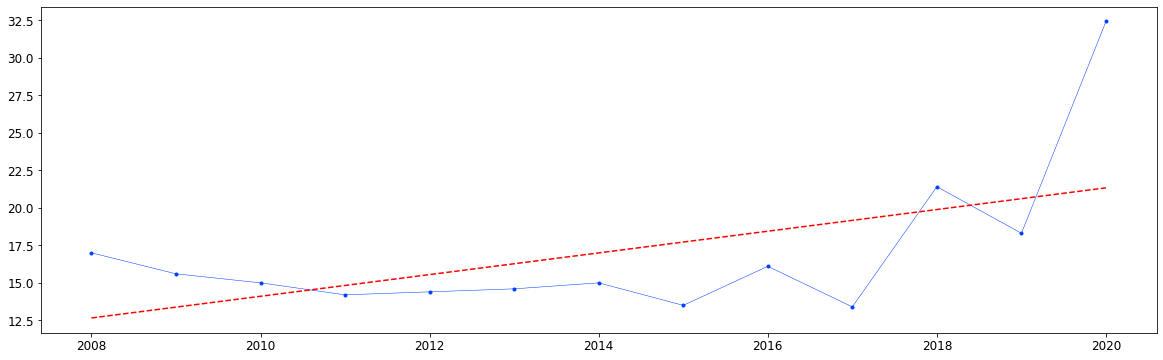

In [151]:

# Stworzenie rysunku i osi
fig, ax = plt.subplots(figsize=(20,6))

# Wykres liniowy
ax.plot(y, marker='.', linestyle='-', linewidth=0.5);

# Linia trendu
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), "r--");

In [152]:
# Ustawienie indeksu z powrotem jako obiektu datetime
msp.index = pd.to_datetime(msp.index, format="%Y")
msp

,udzial_msp
rok,
2008-01-01,17.0
2009-01-01,15.6
2010-01-01,15.0
2011-01-01,14.2
2012-01-01,14.4
2013-01-01,14.6
2014-01-01,15.0
2015-01-01,13.5
2016-01-01,16.1


### 1.3. Dekompozycja

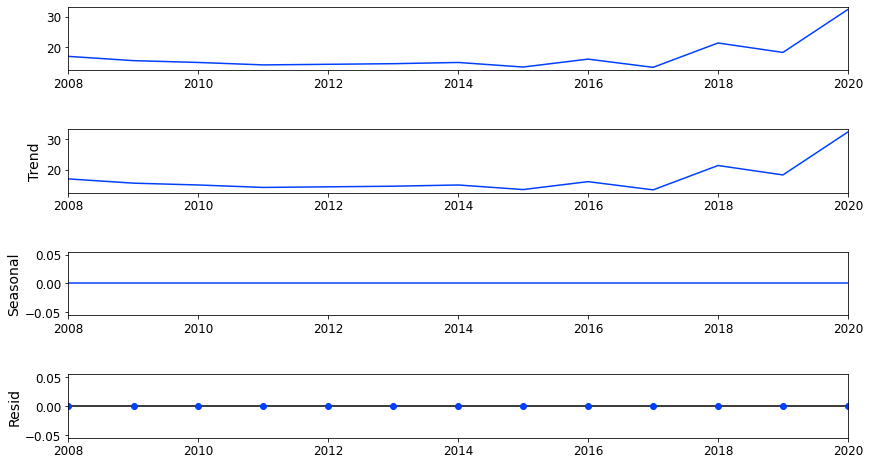

In [153]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose(msp)

In [154]:
msp_2015_plus = msp.iloc[7:,:]

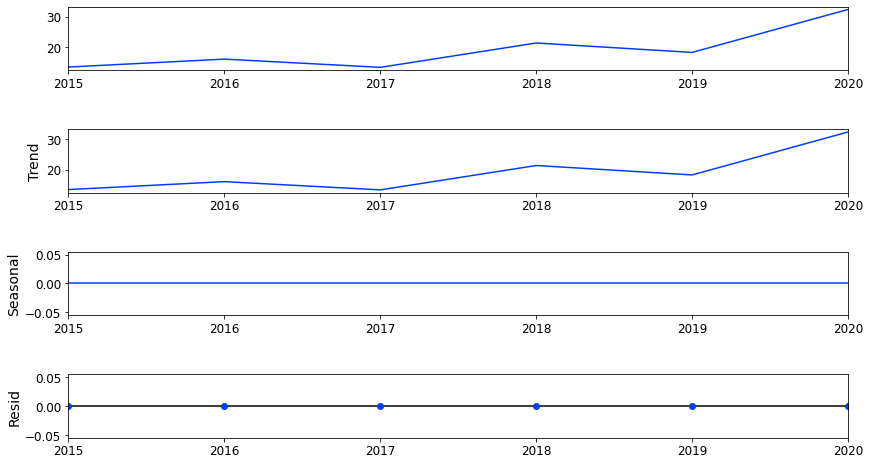

In [155]:
seasonal_decompose(msp_2015_plus)

### 1.4. Stacjonarność

In [156]:
# Import testu
from statsmodels.tsa.stattools import adfuller
# Otrzymanie rezultatów
adf_results = adfuller(msp)
# Wydrukowanie wartości
print("WYNIKI WZMOCNIONEGO TESTU DICKEYA-FULLERA\n")
print(f"Wartość testu Dickeya-Fullera: {adf_results[0]}.\nIm bardziej ujemna wartość - tym większe prawdopodobieństwo, że szereg jest stacjonarny")
print(f"Wartość p: {round(adf_results[1],2)}.")
# Round the critical values
rounded_criticals = {key: round(value, 2) for key, value in adf_results[4].items()}
print(f"Wartości krytyczne p: {rounded_criticals}.\n")

WYNIKI WZMOCNIONEGO TESTU DICKEYA-FULLERA

Wartość testu Dickeya-Fullera: 3.259111916269048.
Im bardziej ujemna wartość - tym większe prawdopodobieństwo, że szereg jest stacjonarny
Wartość p: 1.0.
Wartości krytyczne p: {'1%': -4.22, '5%': -3.19, '10%': -2.73}.



Detrendowanie

In [157]:
msp_stationary = msp.diff().diff().dropna()

# Otrzymanie rezultatów
adf_results = adfuller(msp_stationary)
# Wydrukowanie wartości
print("WYNIKI WZMOCNIONEGO TESTU DICKEYA-FULLERA\n")
print(f"Wartość testu Dickeya-Fullera: {adf_results[0]}.\nIm bardziej ujemna wartość - tym większe prawdopodobieństwo, że szereg jest stacjonarny")
print(f"Wartość p: {round(adf_results[1],2)}.")
# Round the critical values
rounded_criticals = {key: round(value, 2) for key, value in adf_results[4].items()}
print(f"Wartości krytyczne p: {rounded_criticals}.\n")

WYNIKI WZMOCNIONEGO TESTU DICKEYA-FULLERA

Wartość testu Dickeya-Fullera: -24.58327621556224.
Im bardziej ujemna wartość - tym większe prawdopodobieństwo, że szereg jest stacjonarny
Wartość p: 0.0.
Wartości krytyczne p: {'1%': -4.33, '5%': -3.23, '10%': -2.75}.



In [158]:
msp_stationary

,udzial_msp
rok,
2010-01-01,8.000000e-01
2011-01-01,-2.000000e-01
2012-01-01,1.000000e+00
2013-01-01,-1.776357e-15
2014-01-01,2.000000e-01
2015-01-01,-1.900000e+00
2016-01-01,4.100000e+00
2017-01-01,-5.300000e+00
2018-01-01,1.070000e+01


Test Manna-Kendalla na istotność trendu

In [159]:
import pymannkendall as mk

mk.original_test(msp)


Mann_Kendall_Test(trend='no trend', h=False, p=0.463270021399635, z=0.7334729479536554, Tau=0.16666666666666666, s=13.0, var_s=267.6666666666667, slope=0.23333333333333398, intercept=13.599999999999996)

### 1.5. Prognoza

Proste wygładzanie wykładnicze

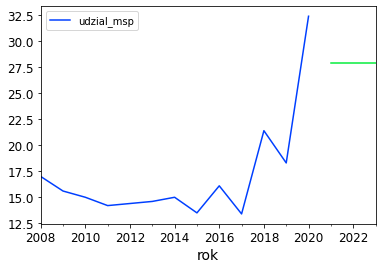

In [160]:
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(msp).fit()
ses.forecast(3)
msp.plot()
ses.forecast(3).plot();

Model Holta

In [161]:
from statsmodels.tsa.api import Holt
holt = Holt(msp).fit()
holt.forecast(3)

2021-01-01    32.239979
2022-01-01    37.321832
2023-01-01    42.403685
Freq: AS-JAN, dtype: float64

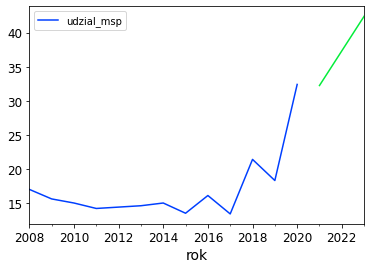

In [162]:
msp.plot()
holt.forecast(3).plot();

Holt z addytywnym trendem

In [163]:
from statsmodels.tsa.api import ExponentialSmoothing

holt_winter = ExponentialSmoothing(msp, seasonal_periods = 2, trend='add', seasonal='mul').fit()
holt_winter.forecast(3)


2021-01-01    25.426154
2022-01-01    38.067587
2023-01-01    31.510048
Freq: AS-JAN, dtype: float64

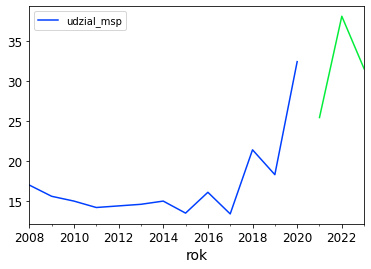

In [164]:
msp.plot()
holt_winter.forecast(3).plot();

## 2. PRZYCHODY Z EKSPORTU

### 1.1. Przygotowanie danych

In [165]:
df = pd.read_excel("dane_strateg.xlsx")

In [166]:
df.rok = pd.to_datetime(df.rok, format="%Y")
df = df.set_index(df.rok.dt.year)
df.drop('rok', axis=1, inplace=True)
df

,udzial_msp,przych_eksport,naklady_inw,przewozy
rok,,,,
2003,.,7867.2,.,.
2004,.,8222.4,.,.
2005,.,8479.2,.,.
2006,.,9233.8,.,.
2007,.,11356.0,.,314.06
2008,17,9883.9,.,309.77
2009,15.6,10877.4,.,272.56
2010,15,12064.3,.,267.97
2011,14.2,15331.2,.,274.4


In [167]:

# Stworzenie zbioru danych dla wskaźnika
eksport = df[['przych_eksport']]


eksport

,przych_eksport
rok,
2003,7867.2
2004,8222.4
2005,8479.2
2006,9233.8
2007,11356.0
2008,9883.9
2009,10877.4
2010,12064.3
2011,15331.2


In [168]:
eksport.przych_eksport = eksport.przych_eksport.astype(float)

### 1.2. Analiza eksploracyjna

In [169]:
# Określenie y
x = eksport.index
y = eksport.przych_eksport


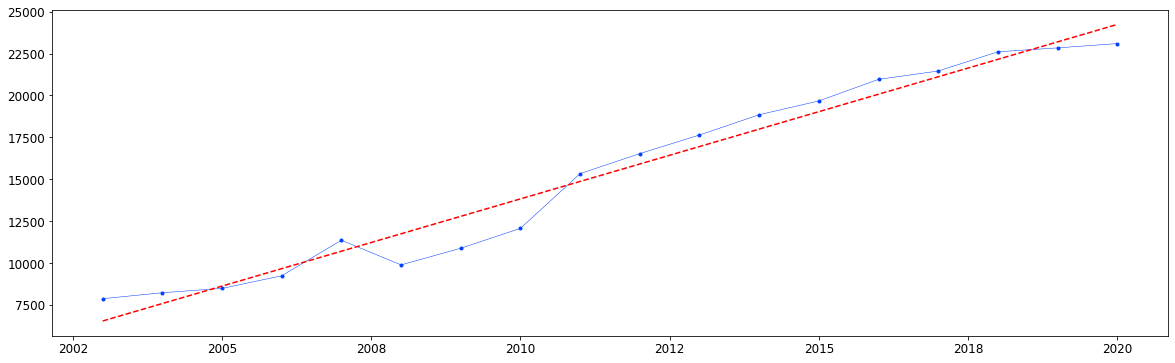

In [170]:
from matplotlib.ticker import FormatStrFormatter

# Stworzenie rysunku i osi
fig, ax = plt.subplots(figsize=(20,6))

# Formatowanie
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Wykres liniowy
ax.plot(y, marker='.', linestyle='-', linewidth=0.5);

# Linia trendu
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), "r--");

In [171]:
# Ustawienie indeksu z powrotem jako obiektu datetime
eksport.index = pd.to_datetime(eksport.index, format="%Y")
eksport

,przych_eksport
rok,
2003-01-01,7867.2
2004-01-01,8222.4
2005-01-01,8479.2
2006-01-01,9233.8
2007-01-01,11356.0
2008-01-01,9883.9
2009-01-01,10877.4
2010-01-01,12064.3
2011-01-01,15331.2


### 1.3. Dekompozycja

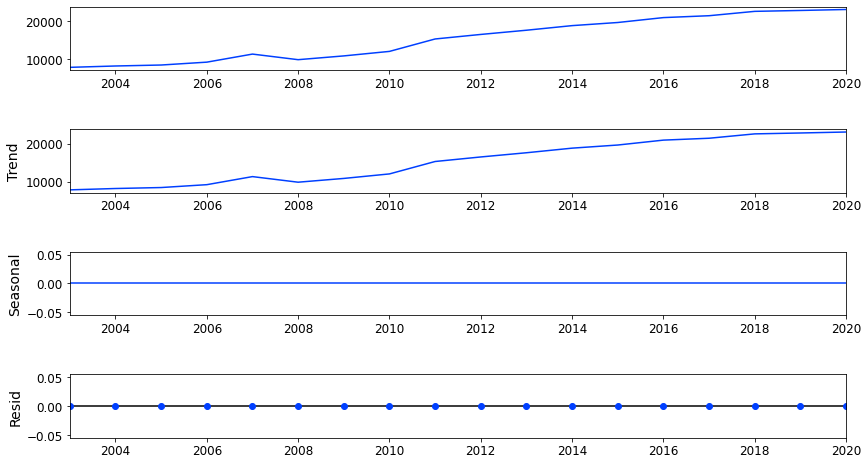

In [172]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose(eksport)

Test Manna-Kendalla na istotność trendu

In [173]:
import pymannkendall as mk

mk.original_test(eksport)


Mann_Kendall_Test(trend='increasing', h=True, p=2.0717586979301927e-08, z=5.605899741181419, Tau=0.9738562091503268, s=149.0, var_s=697.0, slope=1034.0400000000002, intercept=7139.359999999999)

### 1.5. Prognoza

Model Holta

In [174]:
from statsmodels.tsa.api import Holt
holt = Holt(eksport).fit()
holt.forecast(3)

2021-01-01    23876.540564
2022-01-01    24643.349978
2023-01-01    25410.159392
Freq: AS-JAN, dtype: float64

In [175]:
holt_for = holt.forecast(3)

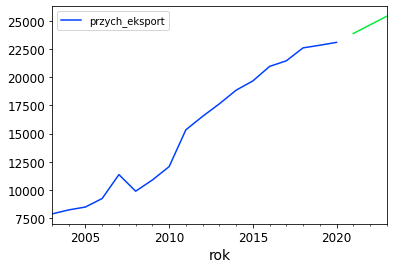

In [176]:
eksport.plot()
holt_for.plot();

In [177]:
eksport.to_excel("eksport_pesym.xlsx")

In [178]:
holt_for.to_excel("eksport_progn.xlsx")

## 4. PRZEWOZY

### 1.1. Przygotowanie danych

In [179]:
df = pd.read_excel("dane_strateg.xlsx")

In [180]:
df.rok = pd.to_datetime(df.rok, format="%Y")
df = df.set_index(df.rok.dt.year)
df.drop('rok', axis=1, inplace=True)
df

,udzial_msp,przych_eksport,naklady_inw,przewozy
rok,,,,
2003,.,7867.2,.,.
2004,.,8222.4,.,.
2005,.,8479.2,.,.
2006,.,9233.8,.,.
2007,.,11356.0,.,314.06
2008,17,9883.9,.,309.77
2009,15.6,10877.4,.,272.56
2010,15,12064.3,.,267.97
2011,14.2,15331.2,.,274.4


In [181]:

# Stworzenie zbioru danych dla wskaźnika
przewozy = df.loc["2008":"2019", "przewozy"].to_frame()


przewozy

,przewozy
rok,
2008,309.77
2009,272.56
2010,267.97
2011,274.4
2012,298.89
2013,306.3
2014,328.4
2015,326.3
2016,336.9


In [182]:

# Stworzenie zbioru danych dla wskaźnika
przewozy_2020 = df.loc["2008":"2020", "przewozy"].to_frame()


przewozy_2020

,przewozy
rok,
2008,309.77
2009,272.56
2010,267.97
2011,274.4
2012,298.89
2013,306.3
2014,328.4
2015,326.3
2016,336.9


In [183]:
przewozy.przewozy = przewozy.przewozy.astype(float)

In [184]:
przewozy_2020.przewozy = przewozy_2020.przewozy.astype(float)

### 1.2. Analiza eksploracyjna

In [185]:
# Określenie y
x = przewozy.index
y = przewozy.przewozy


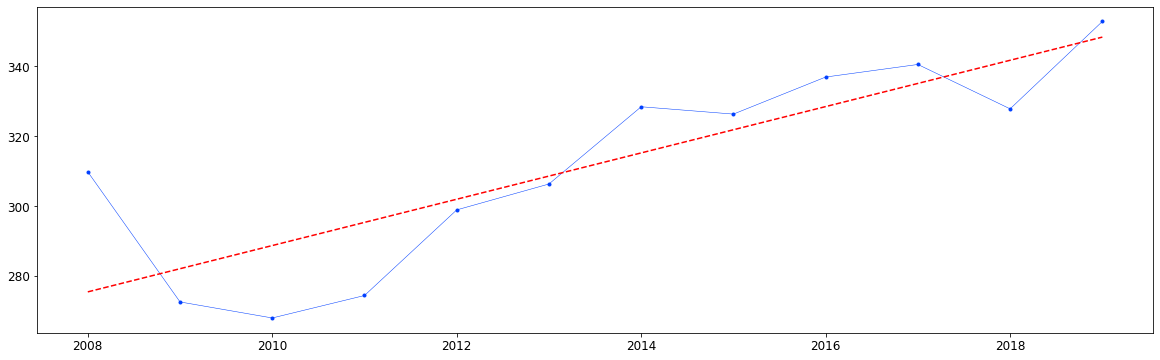

In [186]:
from matplotlib.ticker import FormatStrFormatter

# Stworzenie rysunku i osi
fig, ax = plt.subplots(figsize=(20,6))

# Formatowanie
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Wykres liniowy
ax.plot(y, marker='.', linestyle='-', linewidth=0.5);

# Linia trendu
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), "r--");

In [187]:
# Określenie y
x = przewozy_2020.index
y = przewozy_2020.przewozy


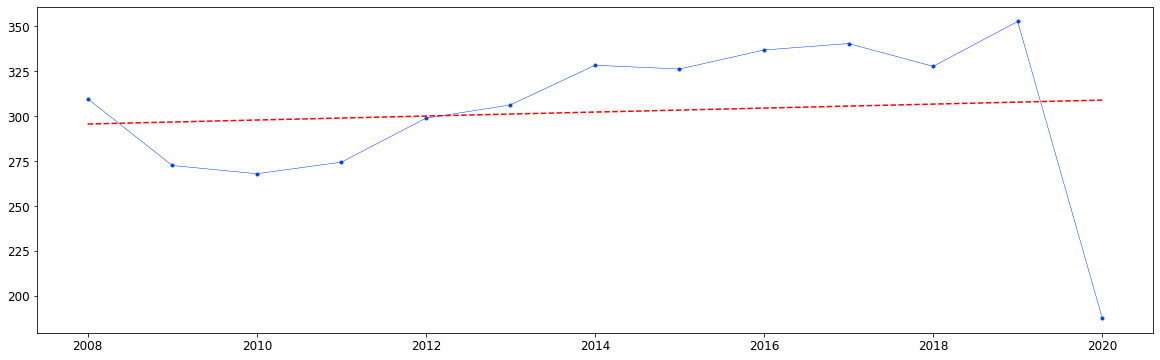

In [188]:
from matplotlib.ticker import FormatStrFormatter

# Stworzenie rysunku i osi
fig, ax = plt.subplots(figsize=(20,6))

# Formatowanie
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Wykres liniowy
ax.plot(y, marker='.', linestyle='-', linewidth=0.5);

# Linia trendu
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), "r--");

In [189]:
# Ustawienie indeksu z powrotem jako obiektu datetime
przewozy.index = pd.to_datetime(przewozy.index, format="%Y")
przewozy

,przewozy
rok,
2008-01-01,309.77
2009-01-01,272.56
2010-01-01,267.97
2011-01-01,274.40
2012-01-01,298.89
2013-01-01,306.30
2014-01-01,328.40
2015-01-01,326.30
2016-01-01,336.90


In [190]:
# Ustawienie indeksu z powrotem jako obiektu datetime
przewozy_2020.index = pd.to_datetime(przewozy_2020.index, format="%Y")
przewozy_2020

,przewozy
rok,
2008-01-01,309.77
2009-01-01,272.56
2010-01-01,267.97
2011-01-01,274.40
2012-01-01,298.89
2013-01-01,306.30
2014-01-01,328.40
2015-01-01,326.30
2016-01-01,336.90


### 1.3. Dekompozycja

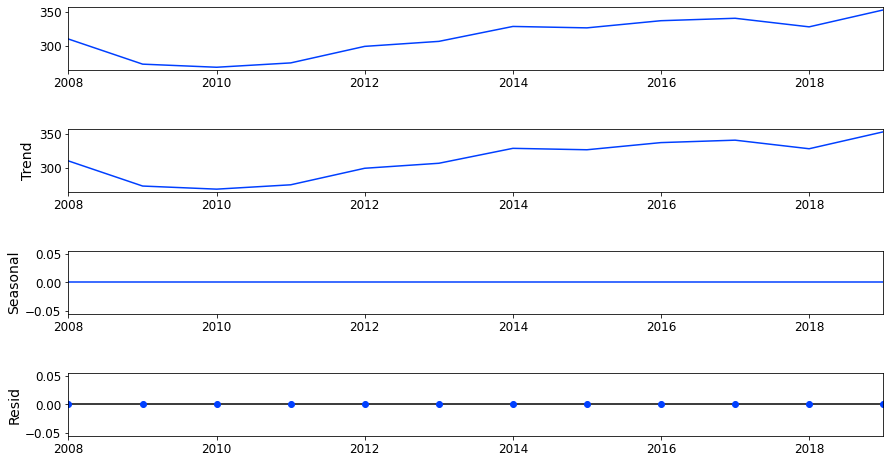

In [191]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose(przewozy)

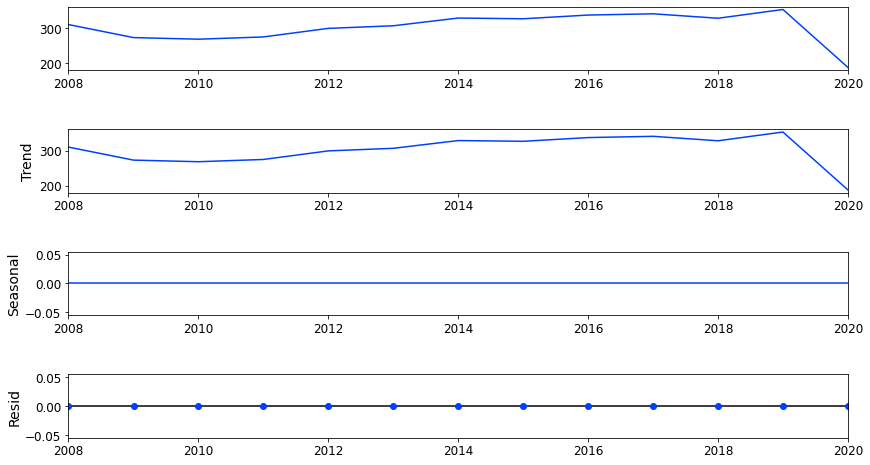

In [192]:
seasonal_decompose(przewozy_2020)

Test Manna-Kendalla na istotność trendu

In [193]:
import pymannkendall as mk

mk.original_test(przewozy)


Mann_Kendall_Test(trend='increasing', h=True, p=0.0020302944356094255, z=3.0857646659568374, Tau=0.696969696969697, s=46.0, var_s=212.66666666666666, slope=7.6650000000000045, intercept=275.87749999999994)

### 1.5. Prognoza

Model Holta

In [194]:
from statsmodels.tsa.api import Holt
holt = Holt(przewozy).fit()
holt.forecast(3)

2020-01-01    361.779674
2021-01-01    375.418834
2022-01-01    389.057995
Freq: AS-JAN, dtype: float64

In [195]:
holt_for = holt.forecast(3)

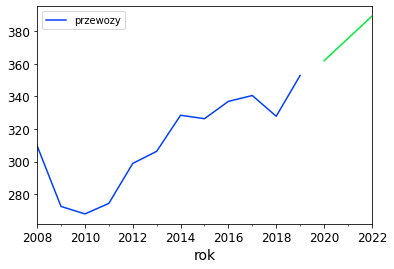

In [196]:
przewozy.plot()
holt_for.plot();

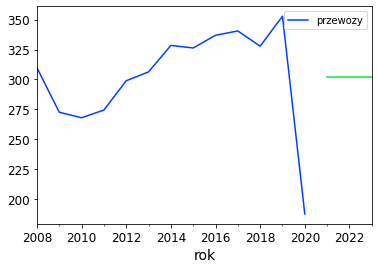

In [197]:
ses = SimpleExpSmoothing(przewozy_2020).fit()
przewozy_2020.plot()
ses.forecast(3).plot();

In [198]:
ses.forecast(3)

2021-01-01    302.319974
2022-01-01    302.319974
2023-01-01    302.319974
Freq: AS-JAN, dtype: float64

## 3. NAKŁADY

### 1.1. Przygotowanie danych

In [199]:
# Stworzenie zbioru danych dla wskaźnika
naklady = df[['naklady_inw']]

# Usunięcie braków danych (zaznaczonych jako kropka, ".")
naklady = naklady[naklady['naklady_inw'] != "."]

# Inspekcja danych
naklady

,naklady_inw
rok,
2013,1022.2
2014,2833.6
2015,4587.1
2016,5492.2
2017,6445.8
2018,7736.1
2019,9734.8
2020,11323


In [200]:
naklady.naklady_inw = naklady.naklady_inw.astype(float)

### 1.2. Analiza eksploracyjna

In [201]:
# Określenie y
x = naklady.index
y = naklady.naklady_inw


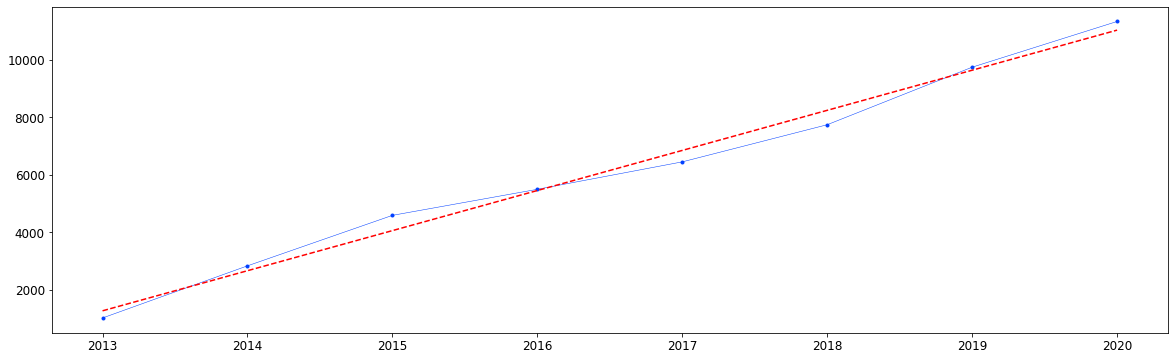

In [202]:

# Stworzenie rysunku i osi
fig, ax = plt.subplots(figsize=(20,6))

# Wykres liniowy
ax.plot(y, marker='.', linestyle='-', linewidth=0.5);

# Linia trendu
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), "r--");

In [203]:
# Ustawienie indeksu z powrotem jako obiektu datetime
naklady.index = pd.to_datetime(naklady.index, format="%Y")
naklady

,naklady_inw
rok,
2013-01-01,1022.2
2014-01-01,2833.6
2015-01-01,4587.1
2016-01-01,5492.2
2017-01-01,6445.8
2018-01-01,7736.1
2019-01-01,9734.8
2020-01-01,11323.0


### 1.3. Dekompozycja

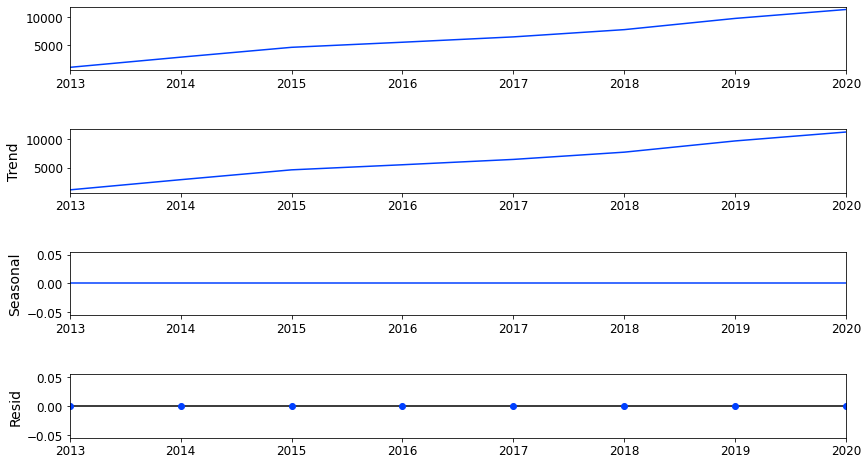

In [204]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose(naklady)

Test Manna-Kendalla na istotność trendu

In [205]:
import pymannkendall as mk

mk.original_test(naklady)


Mann_Kendall_Test(trend='increasing', h=True, p=0.0008366271311193163, z=3.340383700311406, Tau=1.0, s=28.0, var_s=65.33333333333333, slope=1397.2199999999998, intercept=1078.7300000000005)

### 1.5. Prognoza

Model Holta

In [206]:
from statsmodels.tsa.api import Holt
holt = Holt(naklady).fit()
holt.forecast(3)

2021-01-01    12965.127251
2022-01-01    14607.211933
2023-01-01    16249.296614
Freq: AS-JAN, dtype: float64

In [207]:
holt_for = holt.forecast(3)

In [208]:
type(holt_for)

pandas.core.series.Series

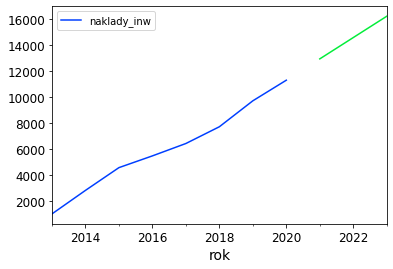

In [209]:
naklady.plot()
holt_for.plot();

In [210]:
naklady.to_excel("naklady_pesym.xlsx")

In [211]:
progn = pd.read_excel("progn_pesym.xlsx", sheet_name=0)

In [212]:
progn = progn.set_index("rok")

<AxesSubplot:xlabel='rok'>

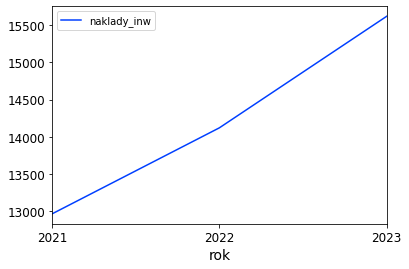

In [213]:
progn.plot()

In [214]:
type(progn)

pandas.core.frame.DataFrame

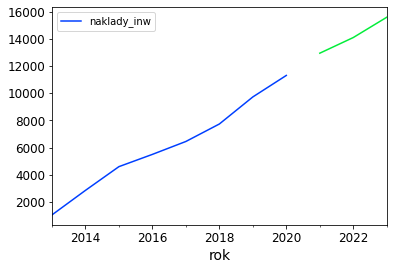

In [215]:
naklady.plot()
progn.squeeze().plot();

In [216]:
progn

,naklady_inw
rok,
2021-01-01,12965.130000
2022-01-01,14121.011583
2023-01-01,15619.620649
